In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf as erf
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

In [2]:
# set some parameters

Mscale = 2.325e9
Vscale = 100
RSun = 8.
Vcirc = 230
Omega = Vcirc/Vscale/RSun
# Mestel disk has A = Omega/2 = -B
A = 0.5*Omega
B = A - Omega
kappa = np.sqrt(-4.*B*Omega)

sigz = 0.25
Q = 1.
SurfaceDensity = 8e7/Mscale
E0 = 3*sigz**2
kyoverkcrit = 1.


def dydx(rho0,y):
    dy = np.zeros(2)
    dy[0] = y[1]
    rho = rho_of_psi(rho0,y[0])
    dy[1] = 4.*np.pi*rho 
    return dy

def rk4(rho0,y,h):
    k1 = dydx(rho0,y)
    k2 = dydx(rho0,y+h*k1/2)
    k3 = dydx(rho0,y+h*k2/2)
    k4 = dydx(rho0,y+h*k3)
    return y + h*(k1+2*k2+2*k3+k4)/6.

def rho_of_psi(rho0,psi):
    if psi > E0:
        return 0.
    u = np.sqrt(E0-psi)/sigz
    return rho0*(np.exp(-psi/sigz**2)*erf(u)-2./np.sqrt(np.pi)*u*np.exp(-E0/sigz**2))


def VerticalStructure(Q,SurfDens,E0,sigz,kyoverkcrit):
    nz = 1000
    hz = sigz**2/(2*np.pi*SurfDens)
    zmx = 10.*hz
    zgrid = np.linspace(0.,zmx,nz,endpoint=False)
    dz = zgrid[1]-zgrid[0]
    ICForce = np.zeros(nz)
    ICPotential = np.zeros(nz)
    ICDensity = np.zeros(nz)
    rho0 = 1e7/Mscale
    for j in range(20):
        y = (ICPotential[0],ICForce[0])
        ICDensity[0] = rho_of_psi(rho0,0.0)
        SD = 0.
        for i in range(1,nz):
            y = rk4(rho0,y,dz)
            ICPotential[i], ICForce[i] = y
            ICDensity[i] = rho_of_psi(rho0,ICPotential[i])
            if ICDensity[i]>0:
                SD += 0.5*(ICDensity[i]+ICDensity[i-1])*dz
        SD = 2.*SD
        MassScaleFactor = SurfDens/SD
        rho0 = rho0*MassScaleFactor

    print ('check convergence of SurfaceDensity',MassScaleFactor)
    print ('central density',ICDensity[0])
#    plt.plot(zgrid,ICPotential/ICPotential.max())
#    plt.plot(zgrid,ICForce)
#   plt.plot(zgrid,ICDensity)
    print ('Omega, Oort A and B',Omega,A,B)
    print ('epicycle kappa',kappa)
    print ('surface density',SurfDens,SurfDens*Mscale/1e6)

    print ('vertical scale height parameter',hz)
    kcrit = kappa**2/2./np.pi/SurfDens
    lcrit = 2.*np.pi/kcrit
    print ('critical wavelength',lcrit)
    ky = kcrit*kyoverkcrit
    sigx = 3.36*Q*SurfDens/kappa
    print ('sigma x',sigx)
    Jeans = sigx**2/SurfDens
    print ('Jeans length',Jeans)
    Repicycle = sigx/kappa
    print ('Epicycle radius',Repicycle)
    Lindblad_kcrit = kappa/2./A/kcrit
    print ('Lindblad resonances for critial k',Lindblad_kcrit)
    iz0 = int(nz/50)
    nuz = np.sqrt(np.sum(2*ICPotential[:iz0])/np.sum(zgrid[:iz0]**2))
    print ('midplane vertical frequency',nuz)
    return rho0,ky,kcrit,sigx,hz,nuz,nz,zgrid,ICDensity,ICForce,ICPotential

rho0,ky,kcrit,sigx,hz,nuz,nz,zgrid,ICDensity,ICForce,ICPotential = \
VerticalStructure(Q,SurfaceDensity,E0,sigz,kyoverkcrit)

lcrit = 2.*np.pi/kcrit
print ('critical wavelength',lcrit)

check convergence of SurfaceDensity 1.0000021753535928
central density 0.038102471812085335
Omega, Oort A and B 0.2875 0.14375 -0.14375
epicycle kappa 0.4065863991822648
surface density 0.034408602150537634 80.0
vertical scale height parameter 0.28909003335051303
critical wavelength 8.217147311190116
sigma x 0.2843501490908933
Jeans length 2.349848649307885
Epicycle radius 0.6993597170559182
Lindblad resonances for critial k 1.8495079491327389
midplane vertical frequency 0.6914952215081136
critical wavelength 8.217147311190116


In [3]:
def get_bc_vectors(t,s,ky,to):
    tto = t - to
    sto = s - to
    Ct = np.cos(kappa*t)
    Cs = np.cos(kappa*s)
    St = np.sin(kappa*t)
    Ss = np.sin(kappa*s)
    bx = ky/kcrit*(A*(sto*Ss-tto*St)+Omega/kappa*(Cs-Ct))
    by = ky/kcrit*(A*(sto*Cs-tto*Ct)-Omega/kappa*(Ss-St))
    cx = -A*sto*Cs + Omega/kappa*Ss
    cy =  A*sto*Ss + Omega/kappa*Cs
    return bx,by,cx,cy

def get_ampfac(s,to):
    sto = s - to
    return (1. + (2*A*sto)**2)**(-.5)

def argexp(b2):
    return -0.572*Q**2*b2

def get_Kpts(t,s,ky,to):
    bx,by,cx,cy = get_bc_vectors(t,s,ky,to)
    cdotb = bx*cx + by*cy
    b2 = bx*bx + by*by
    ampfac = get_ampfac(s,to)
    return 4*cdotb*np.exp(argexp(b2))*ampfac

def get_Kzts(t,s,ky,to):
    bx,by,cx,cy = get_bc_vectors(t,s,ky,to)
    b2 = bx*bx + by*by
    ampfac = get_ampfac(s,to)
    return np.exp(argexp(b2))

In [4]:
# get vertical structure
# need rho0 (midplane density), E0 (energy cut-off)
# and sigz (vertical velocity dispersion)

def loweredisothermal(E):
    if E > E0:
        return 0.
    f0 = rho0/np.sqrt(2.*np.pi)/sigz
    return f0*(np.exp(-E/sigz**2) - np.exp(-E0/sigz**2))

def dloweredisothermal(E):
    if E >= E0:
        return 0.
    f0 = rho0/np.sqrt(2.*np.pi)/sigz
    return f0*np.exp(-E/sigz**2)

def loweredisothermalA(E):
    f0 = np.zeros_like(E)
    cnd = E<E0
    f0[cnd] = rho0/np.sqrt(2.*np.pi)/sigz*(np.exp(-E[cnd]/sigz**2)-np.exp(-E0/sigz**2))
    return f0

def dloweredisothermalA(E):
    f0 = np.zeros_like(E)
    cnd = E<E0
    f0[cnd] = rho0/np.sqrt(2.*np.pi)/sigz*np.exp(-E[cnd]/sigz**2)
    return f0

In [5]:
xmax = lcrit/2.
nx = 33
ymax = lcrit
ny = 66
xgrid = np.linspace(-xmax,xmax,nx)
dx = xgrid[1]-xgrid[0]
ygrid = np.linspace(-ymax,ymax,ny)
dy = ygrid[1]-ygrid[0]
xmesh,ymesh = np.meshgrid(xgrid,ygrid,indexing='ij')
x2mesh = (xmesh)**2 + (ymesh)**2
Delta = 0.05*lcrit
Sigma_0x = np.exp(-x2mesh/Delta**2/2.)

In [6]:
dx = xgrid[1]-xgrid[0]
kmax = np.pi/dx/5.
nkx = nx
nky = int(ny/2)
kxgrid = np.linspace(-kmax,kmax,nkx)
dk = kxgrid[1]-kxgrid[0]
kygrid = np.linspace(0,kmax,nky)
print (kygrid[1]/kcrit)
kxmesh,kymesh = np.meshgrid(kxgrid,kygrid,indexing='ij')
Sigma_0k = np.zeros((nkx,nky),dtype='complex')
for i in range(nkx):
    for j in range(nky):
        FTarg = -1j*(kxgrid[i]*xmesh + kygrid[j]*ymesh)
        FTint = np.exp(FTarg)*Sigma_0x
        FTy = np.trapz(FTint,xgrid,axis=0)
        Sigma_0k[i,j] = np.trapz(FTy,ygrid)

0.09999999999999999


CPU times: user 124 ms, sys: 33.4 ms, total: 157 ms
Wall time: 156 ms


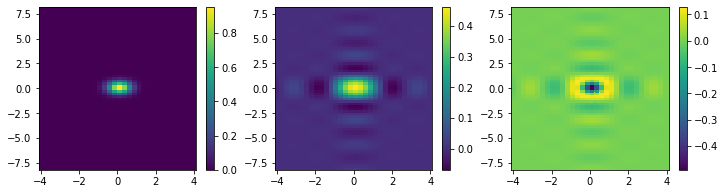

In [7]:
%%time
def inverseFT(ftilde):
    f = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            FTarg = 1j*(xgrid[i]*kxmesh + ygrid[j]*kymesh)
            FTint = np.exp(FTarg)*ftilde
            FTy = np.trapz(FTint,kygrid,axis=3)
            f[i,j] = np.real(np.trapz(FTy,kxgrid)+np.trapz(np.conj(FTy),kxgrid))/(2*np.pi)**2
    return f

def inverseFT_fast(ftilde):
    FTarg = 1j*(np.outer(xmesh,kxmesh)+np.outer(ymesh,kymesh)).reshape(nx,ny,nkx,nky)
    FTint = np.exp(FTarg)*ftilde
    FTy = np.trapz(FTint,kxgrid,axis=2)
    f = np.real(np.trapz(FTy,kygrid,axis=2)+\
        np.trapz(np.conj(FTy),kygrid,axis=2))/(2.*np.pi)**2
    return f

f = inverseFT_fast(Sigma_0k)

fig,ax = plt.subplots(1,3,figsize=(12,3))
c0 = ax[0].pcolormesh(xmesh,ymesh,Sigma_0x)
plt.colorbar(c0,ax=ax[0])
c1 = ax[1].pcolormesh(xmesh,ymesh,f)
plt.colorbar(c1,ax=ax[1])
c2 = ax[2].pcolormesh(xmesh,ymesh,f-Sigma_0x)
plt.colorbar(c2,ax=ax[2])

In [8]:
#make Binney Figure 3

Q = 1.

rho0,ky,kcrit,sigx,hz,nuz,nz,zgrid,ICDensity,ICForce,ICPotential = \
VerticalStructure(Q,SurfaceDensity,E0,sigz,kyoverkcrit)

lcrit = 2.*np.pi/kcrit
print ('critical wavelength',lcrit)

ns = 4
Sigma_s = np.zeros((ns,ntime))
Sigma_e = np.zeros((ns,ntime))
tstart = np.pi/kappa*np.linspace(-2,-.5,ns)
tend = 5.*np.pi/kappa

ky = kcrit
t = np.zeros((ns,ntime))
tr = 0.

for k in range(ns):
    t[k,] = np.linspace(tstart[k],tend,ntime)
    dt = t[k,1]-t[k,0]
    for i in range(ntime):
        Sigma_e[k,i] = get_Kpts(t[k,i],tstart[k],ky,tr)
        Sigma_s[k,i] = Sigma_e[k,i]
        for j in range(1,i):
            Sigma_s[k,i] += dt*kappa*get_Kpts(t[k,i],t[k,j],ky,tr)*Sigma_s[k,j]
        
for k in range(4):
    plt.plot(t[k,]*kappa/np.pi,np.real(Sigma_s[k,]))

check convergence of SurfaceDensity 1.0000021753535928
central density 0.038102471812085335
Omega, Oort A and B 0.2875 0.14375 -0.14375
epicycle kappa 0.4065863991822648
surface density 0.034408602150537634 80.0
vertical scale height parameter 0.28909003335051303
critical wavelength 8.217147311190116
sigma x 0.2843501490908933
Jeans length 2.349848649307885
Epicycle radius 0.6993597170559182
Lindblad resonances for critial k 1.8495079491327389
midplane vertical frequency 0.6914952215081136
critical wavelength 8.217147311190116


NameError: name 'ntime' is not defined

In [ ]:
# now make Binney Figure 8

Q = 1.4

rho0,ky,kcrit,sigx,hz,nuz,nz,zgrid,ICDensity,ICForce,ICPotential = \
VerticalStructure(Q,SurfaceDensity,E0,sigz,kyoverkcrit)

lcrit = 2.*np.pi/kcrit
print ('critical wavelength',lcrit)
ky = kcrit/2.

ns = 6
tstart = np.pi/kappa*np.linspace(-5,0,ns)
t = np.zeros((ns,ntime))
Sigma_s = np.zeros((ns,ntime))

for k in range(ns):
    t[k,] = np.linspace(tstart[k],tend,ntime)
    dt = t[k,1]-t[k,0]
    for i in range(ntime):
        for j in range(1,i):
            prefac = dt*kappa*get_Kpts(t[k,i],t[k,j],ky,0.)
            Sigma_s[k,i] += prefac*(1.+Sigma_s[k,j])
        
for k in range(ns):
    plt.plot(t[k,]*kappa/np.pi,np.real(Sigma_s[k,]))

check convergence of SurfaceDensity 1.0000021753535928
central density 0.038102471812085335
Omega, Oort A and B 0.2875 0.14375 -0.14375
epicycle kappa 0.4065863991822648
surface density 0.034408602150537634 80.0
vertical scale height parameter 0.28909003335051303
critical wavelength 8.217147311190116
sigma x 0.3980902087272506
Jeans length 4.605703352643454
Epicycle radius 0.9791036038782853
Lindblad resonances for critial k 1.8495079491327389
midplane vertical frequency 0.6914952215081136
critical wavelength 8.217147311190116
(50,)
0.7499999999999999
0.5
0.25
-0.0
-0.25
-0.5
-0.7499999999999999
-1.0


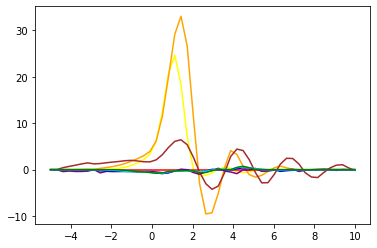

In [626]:
# now make Binney Figure 8

Q = 1.4

rho0,ky,kcrit,sigx,hz,nuz,nz,zgrid,ICDensity,ICForce,ICPotential = \
VerticalStructure(Q,SurfaceDensity,E0,sigz,kyoverkcrit)

lcrit = 2.*np.pi/kcrit
print ('critical wavelength',lcrit)

ns = 8
tstart = -5.*np.pi/kappa
t = np.linspace(tstart,2.*tend,ntime)
print (t.shape)
dt = t[1]-t[0]
Sigma_s = np.zeros((ns,ntime))

for k in range(ns):
    ky = -.25*kcrit*np.float(k-3)
    print (ky/kcrit)
    for i in range(ntime):
        for j in range(1,i):
            prefac = dt*kappa*get_Kpts(t[i],t[j],ky,0.)
            Sigma_s[k,i] += prefac*(1.+Sigma_s[k,j])
            
c = ['yellow','orange','brown','red','purple','blue','cyan','green']
for k in range(ns):
    plt.plot(t*kappa/np.pi,np.real(Sigma_s[k,]),color=c[k])

In [593]:
# now let's go for Figure 9 of Binney

tr = np.zeros_like(kxmesh)
cnd = kymesh!=0
tr[cnd] = -kxmesh[cnd]/kymesh[cnd]/2./A
print (tr.min(),tr.max())

ntime = 50
ti = -10*np.pi/kappa
tf = 10.*np.pi/kappa
print (tf)
tt = np.linspace(ti,tf,ntime)
dt = tt[1]-tt[0]

Sigma_sk = np.zeros((ntime,nkx,nky),dtype=complex)
for i in range(nkx):
    for j in range(nky):
        for k in range(ntime):
            for l in range(1,k):
                prefac = kappa*dt*get_Kpts(tt[k],tt[l],kymesh[i,j],tr[i,j]) 
                if kymesh[i,j] != 0.:
                    Sigma_sk[k,i,j] += prefac*(1.+Sigma_sk[l,i,j])

-111.30434782608697 111.30434782608697
77.26752935927594


In [608]:
# now let's go for Figure 9 of Binney

tr = np.zeros_like(kxmesh)
cnd = kymesh!=0
tr[cnd] = -kxmesh[cnd]/kymesh[cnd]/2./A
print (tr.min(),tr.max())

ntime = 50
ti = -10*np.pi/kappa
tf = 10.*np.pi/kappa
print (tf)
tt = np.linspace(ti,tf,ntime)
dt = tt[1]-tt[0]

Sigma_sk = np.zeros((ntime,nkx,nky),dtype=complex)
for i in range(nkx):
    for j in range(nky):
        for k in range(ntime):
            for l in range(1,k):
                prefac = kappa*dt*get_Kpts(tt[k],tt[l],kymesh[i,j],tr[i,j]) 
                if kymesh[i,j] != 0.:
                    Sigma_sk[k,i,j] += prefac*(1.+Sigma_sk[l,i,j])

-111.30434782608697 111.30434782608697
77.26752935927594


KeyboardInterrupt: 

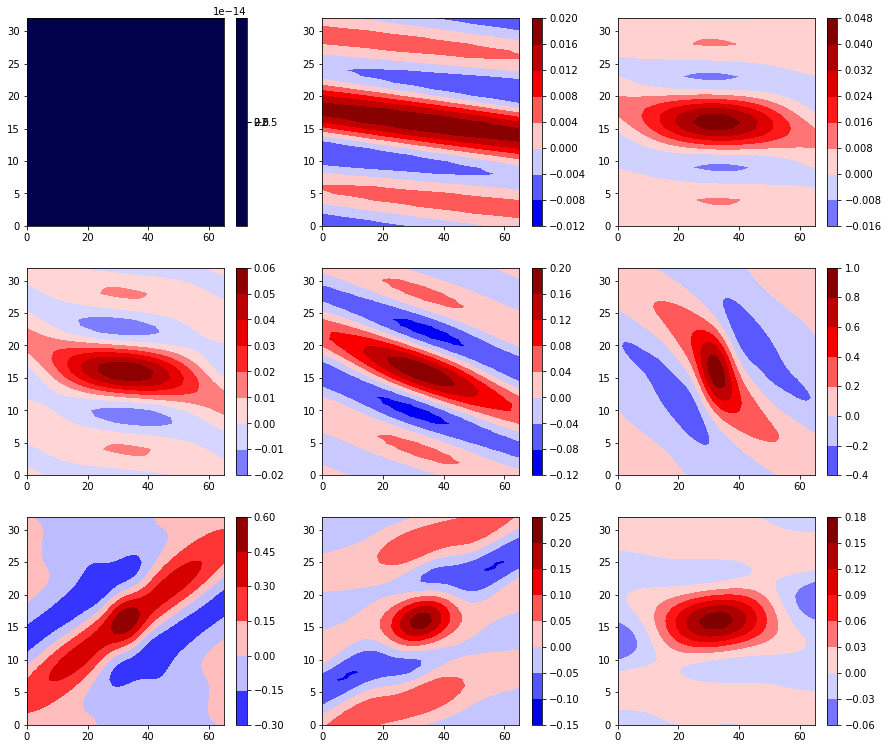

In [594]:
def PlotSDfromFT(Sigma_k):
    ncol = 3
    nrow = 3
    npan = ncol*nrow
    skip = int(ntime/npan)
    Sigma_x = np.zeros((nx,ny))
    fig,ax = plt.subplots(nrow,ncol,figsize=(15,13))
    for i in range(nrow):
        for j in range(ncol):
            nt = skip*(i*nrow + j)
            Sigma_x = inverseFT_fast(Sigma_k[nt,]*Sigma_0k)
            vmx = np.abs(Sigma_x).max()
            c = ax[i,j].contourf(Sigma_x,vmin=-vmx,vmax=vmx,cmap='seismic')
            plt.colorbar(c,ax=ax[i,j])
            
PlotSDfromFT(Sigma_sk)

0.09999999999999999 0.0


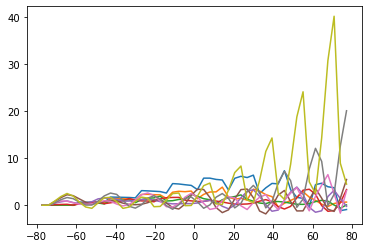

In [601]:
print (kygrid[1]/kcrit,kxgrid[16]/kcrit)


for i in range(0,nkx,4):
    plt.plot(tt,Sigma_sk[:,i,1])

In [12]:
psifromz = interpolate.interp1d(zgrid,ICPotential,fill_value='extrapolate')
zfrompsi = interpolate.interp1d(ICPotential,zgrid,fill_value='extrapolate')
forcefromz = interpolate.interp1d(zgrid,ICForce,fill_value='extrapolate')

In [13]:
def dydxa(Em,t,z):
    psi = psifromz(z)
    if Em < psi:
        return 0.
    return (1./np.sqrt(2.*(Em-psi)))

def rk4a(Em,t,z,h):
    k1 = dydxa(Em,t,z)
    k2 = dydxa(Em,t+h*k1/2,z+h/2)
    k3 = dydxa(Em,t+h*k2/2,z+h/2)
    k4 = dydxa(Em,t+h*k3,z+h)
    return t + h*(k1+2*k2+2*k3+k4)/6.

nE = 100
nz = 100
nt = 100

Eg = np.linspace(0,E0,nE)
zmax = zfrompsi(Eg)
zmax[0] = zfrompsi(Eg[1]/100)
tofEz = np.zeros((nE,nz))
zg = np.linspace(0,zmax[0],nz)
zgs = np.linspace(0,1,nz)
tofEz[0,:] = 1/nuz*np.arcsin(zg/zmax[0])
for i in range(1,nE):
    zg = np.linspace(0,zmax[i],nz)
    h = zg[1]-zg[0]
    for j in range(1,nz-1):
        tofEz[i,j] = rk4a(Eg[i],tofEz[i,j-1],zg[j-1],h)
    lastz = np.sqrt(2.*h/forcefromz(zg[nz-1]))
    tofEz[i,nz-1] = tofEz[i,nz-2] + lastz
    
Period = 4.*tofEz[:,nz-1]
PeriodfromE = interpolate.interp1d(Eg,Period,fill_value='extrapolate')
theta = np.zeros_like(tofEz)

for i in range(0,nE):
    theta[i,:] = 2.*np.pi*tofEz[i,:]/Period[i]

In [14]:
def dydxb(Em,z,t):
    psi = psifromz(z)
    if Em < psi:
        return 0.
    return (np.sqrt(2.*(Em-psi)))

def rk4b(Em,z,t,h):
    k1 = dydxb(Em,z,t)
    k2 = dydxb(Em,z+h*k1/2,t+h/2)
    k3 = dydxb(Em,z+h*k2/2,t+h/2)
    k4 = dydxb(Em,z+h*k3,t+h)
    return z + h*(k1+2*k2+2*k3+k4)/6.

zofEt = np.zeros((nE,nt))
thetag = np.linspace(0,np.pi/2,nt)
for i in range(1,nE):
    tg = np.linspace(0,Period[i]/4.,nt)
    h = tg[1]-tg[0]
    for j in range(1,nt):
        zofEt[i,j] = rk4b(Eg[i],zofEt[i,j-1],tg[j-1],h)

In [15]:
thetainterp = RegularGridInterpolator((Eg,zgs),theta,bounds_error=False)
zoftinterp = RegularGridInterpolator((Eg,thetag),zofEt,bounds_error=False)

In [16]:
def thetafromzw(z,w):
    E = 0.5*w**2 + psifromz(np.abs(z))
    if E >= E0:
        return 0.
    zmx = zfrompsi(E)
    theta = thetainterp((E,np.abs(z)/zmx))
    if z > 0 and w < 0:
        return np.pi - theta
    if z < 0 and w > 0:
        return 2.*np.pi - theta
    if z < 0 and w < 0:
        return np.pi + theta
    return theta

def thetafromzw_fast(z,w):
    E = 0.5*w**2 + psifromz(np.abs(z))
    zmx = zfrompsi(E)
    theta = np.pi/2.*np.ones_like(E)
    c0b = w!=0
    theta[c0b] = thetainterp((E[c0b],np.abs(z[c0b])/zmx[c0b]))
    c1 = (z>0) & (w<0)
    theta[c1] = np.pi - theta[c1]
    c2 = (z<0) & (w>0)
    theta[c2] = 2.*np.pi - theta[c2]
    c3 = (z<0) & (w<0)
    theta[c3] = np.pi + theta[c3]
    return theta

def wzoftfromEtheta(E,theta):
    zsign = 1
    wsign = 1
    theta = np.mod(theta,2*np.pi)
    if theta > np.pi/2. and theta < np.pi:
        theta = np.pi - theta
        wsign = -1
    if theta > np.pi and theta < 3*np.pi/2.:
        zsign = -1
        wsign = -1
        theta = theta - np.pi
    if theta > 3.*np.pi/2.:
        zsign = -1
        theta = 2*np.pi - theta
    zoft = zoftinterp((E,theta))*zsign
    psi = psifromz(np.abs(zoft))
    if (E < psi):
        woft = 0.
    else:
        woft = np.sqrt(2.*(E - psifromz(np.abs(zoft))))*wsign
    return zoft,woft

def wzoftfromEtheta_fast(E,theta):
    zsign = np.ones_like(E)
    wsign = np.ones_like(E)
    theta = np.mod(theta,2*np.pi)

    cnd = (theta>np.pi/2.) & (theta < np.pi)
    theta[cnd] = np.pi - theta[cnd]
    wsign[cnd] = -1
    
    cnd = (theta > np.pi) & (theta < 3.*np.pi/2.)
    theta[cnd] -= np.pi
    zsign[cnd] = -1
    wsign[cnd] = -1
    
    cnd = theta > 3.*np.pi/2.
    theta[cnd] = 2.*np.pi - theta[cnd]
    zsign[cnd] = -1

    zoft = zoftinterp((E,theta))*zsign
    psi = psifromz(np.abs(zoft))
    cdn = E < psi
    woft = np.zeros_like(E)
    cnd = E > psi
    woft[cnd] = np.sqrt(2.*(E[cnd] - psi[cnd]))*wsign[cnd]
    return zoft,woft

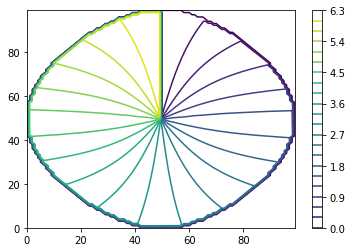

In [17]:
vmax = np.sqrt(2.*E0)
ztrunc = zfrompsi(E0)
vg = np.linspace(-vmax,vmax,nz)
zg = np.linspace(-ztrunc,ztrunc,nz)
zm,vm = np.meshgrid(zg,vg)
tm = np.zeros_like(zm)
for i in range(nz):
    for j in range(nz):
        tm[i,j] = thetafromzw(zm[i,j],vm[i,j])
        
plt.contour(tm,levels=20)
plt.colorbar()

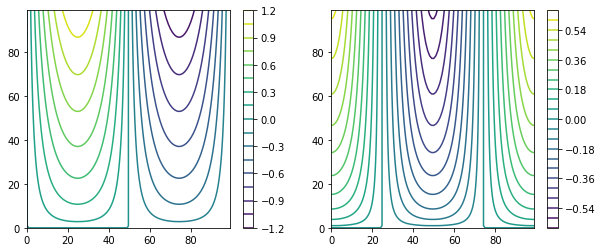

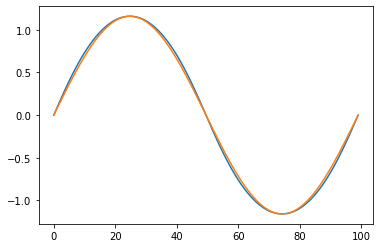

In [18]:
thetagrid = np.linspace(0,2*np.pi,nz)
Egrid = np.linspace(0,E0,nE)
tm,Em = np.meshgrid(thetagrid,Egrid)
zm = np.zeros_like(tm)
wm = np.zeros_like(tm)
for i in range(nz):
    for j in range(nz):
        zm[i,j],wm[i,j] = wzoftfromEtheta(Em[i,j],tm[i,j])

f,ax = plt.subplots(1,2,figsize=(10,4))
c0 = ax[0].contour(zm,levels=20)
plt.colorbar(c0,ax=ax[0])
c1 = ax[1].contour(wm,levels=20)
plt.colorbar(c1,ax=ax[1])
plt.show()

plt.plot(zm[nz-1,])
plt.plot(np.sin(thetagrid)*zfrompsi(Egrid[nz-1]))

In [19]:
def ztprime(t,s,z,w):
    E = 0.5*w**2 + psifromz(np.abs(z))
    if E == 0:
        return 0.0,0.0
    if E > E0:
        print ('here',z,w,E,E0)
        return np.inf,np.inf
    nu = 2.*np.pi/PeriodfromE(E)
    theta = thetafromzw(z,w)
    thetap = theta - nu*(t-s)
    ztp, wtp = wzoftfromEtheta(E,thetap)
    if np.isnan(ztp):
        print (z,w,E,nu,theta,thetap,ztp)
        ;lskdjf
    return ztp, wtp

def ztprime_fast(t,s,z,w):
    E = 0.5*w**2 + psifromz(np.abs(z))
    cnd = E != 0.
    nu = np.zeros_like(z)
    theta = np.zeros_like(z)
    ztp = np.zeros_like(z)
    wtp = np.zeros_like(z)
    nu[cnd] = 2.*np.pi/PeriodfromE(E[cnd])
    theta[cnd] = thetafromzw_fast(z[cnd],w[cnd])-nu[cnd]*(t-s)
    ztp[cnd], wtp[cnd] = wzoftfromEtheta_fast(E[cnd],theta[cnd])
    return ztp, wtp

In [20]:
# in this module, we calculate the normalization factor by 
# integrating the density via loweredisothermal(Ez) over z and w


def get_greensfac(zs,zeta,s,to):
    kp = ky/get_ampfac(s,to)
    gf = np.exp(-kp*np.abs(zs-zeta))
    return gf

zeta = 0.
nPS = 32
zmaxPS = zfrompsi(E0)
zPS = np.linspace(-zmaxPS,zmaxPS,nPS)
dzPS = zPS[1]-zPS[0]
wmx = np.sqrt(2.*E0)
dwPS = 2*wmx/np.float(nPS-1)
wPS = np.linspace(-wmx,wmx,nPS)

zPSM, wPSM = np.meshgrid(zPS,wPS)
EPSM = 0.5*wPSM**2 + psifromz(np.abs(zPSM))

SDPS = 0.
for i in range(1,nPS-1):
    psi = psifromz(np.abs(zPS[i]))
    if psi < E0:
        wmx = np.sqrt(2.*(E0-psi))
        wPSN = np.linspace(-wmx,wmx,nPS)
        dwPSN = wPSN[1]-wPSN[0]
        for j in range(1,nPS-1):
            Ez = 0.5*wPSN[j]**2 + psi
            SDPS += dwPSN*dzPS*loweredisothermal(Ez)
normalization = 1./SDPS
print ('normalization',normalization)

def get_df(Ez):
    return normalization*loweredisothermal(Ez)

def get_ddf(Ez):
    ddf = np.zeros_like(Ez)
    ddf[Ez<=E0] = normalization*dloweredisothermal(Ez)
    return ddf

def get_dfA(Ez):
    return normalization*loweredisothermalA(Ez)

def get_ddfA(Ez):
    return normalization*dloweredisothermalA(Ez)

def get_fe_zwt(t,s,z,zeta,w):
    Ez = 0.5*w**2 + psifromz(np.abs(z))
    if Ez >= E0:
        return 0.0,0.0
    zs, ws = ztprime(t,s,z,w)
    greensfac = get_greensfac(zs,zeta,s)
    fpe = greensfac*get_Kpts(t,s)*get_df(Ez)
    fze = -ws/kappa/hz*greensfac*get_Kzts(t,s)*get_ddf(Ez)*np.sign(zs-zeta)
    return fpe,fze

def get_fe_zwt_fast(t,s,to,z,zeta,w):
    zs = np.zeros_like(z)
    ws = np.zeros_like(z)
    Ez = 0.5*w**2 + psifromz(np.abs(z))
    fpe = np.zeros_like(z)
    fze = np.zeros_like(z)
    cnd = Ez<E0
    zs[cnd], ws[cnd] = ztprime_fast(t,s,z[cnd],w[cnd])
    greensfac = get_greensfac(zs,zeta,s,to)
    fpe[cnd] = greensfac[cnd]*get_Kpts(t,s,to)*get_dfA(Ez[cnd])
    fze[cnd] = -ws[cnd]/kappa/hz*greensfac[cnd]*get_Kzts(t,s,to)* \
        get_ddfA(Ez[cnd])*np.sign(zs[cnd]-zeta)
    return fpe,fze

normalization 29.072062699965542


In [21]:
%%time

def get_fs_zwt_fast(t,s,to,z,w,rho1):
    zs, ws = ztprime_fast(t,s,z,w)
    Ez = 0.5*w**2 + psifromz(np.abs(z))
    cnd = Ez < E0
    fps = np.zeros_like(Ez)
    fzs = np.zeros_like(Ez)
    for i in range(1,nPS-1):
        greensfac = np.zeros_like(Ez)
        greensfac[cnd] = get_greensfac(zs[cnd],zPS[i],s,to)
        fps[cnd] += greensfac[cnd]*rho1[i]*dzPS
        fzs[cnd] += greensfac[cnd]*rho1[i]*dzPS*ws[cnd]*np.sign(zs[cnd]-zPS[i])
    return fps,fzs

f_kpe = np.zeros((ntime,nkx,nky,nPS,nPS))
f_kze = np.zeros_like(f_kpe)
f_kps = np.zeros_like(f_kze)
f_kzs = np.zeros_like(f_kze)
rho_kps = np.zeros((ntime,nkx,nky,nPS))
rho_kzs = np.zeros_like(rho_kps)
rho_kpe = np.zeros_like(rho_kps)
rho_kze = np.zeros_like(rho_kps)
Sigma_kps = np.zeros((ntime,nkx,nky),dtype=complex)
Sigma_kzs = np.zeros_like(Sigma_kps)
Sigma_kpe = np.zeros_like(Sigma_kps)
Sigma_kze = np.zeros_like(Sigma_kps)

Ez = 0.5*wPSM**2 + psifromz(np.abs(zPSM))

for k in range(1,ntime):
    print (k,end='  ')
    for i in range(nkx):
        for j in range(nky):
            f_kpe[k,i,j,],f_kze[k,i,j,] = get_fe_zwt_fast(t[k],tstart,tr[i,j],zPSM,zeta,wPSM)
            f_kps[k,i,j,] = f_kpe[k,i,j,]
            f_kzs[k,i,j,] = f_kze[k,i,j,]
            for m in range(1,k):
                kpts = kappa*get_Kpts(t[k],t[m],tr[i,j])
                kzts = -1./hz*get_Kzts(t[k],t[m],tr[i,j])
                fps,fzs = get_fs_zwt_fast(t[k],t[m],tr[i,j],zPSM,wPSM,rho_kps[m,i,j,]+rho_kzs[m,i,j,])
                f_kps[k,i,j,] += fps*kpts*get_dfA(Ez)*dt
                f_kzs[k,i,j,] += fzs*kzts*get_ddfA(Ez)*dt
            rho_kps[k,i,j,] = np.trapz(f_kps[k,i,j,],wPS,axis=1)
            rho_kzs[k,i,j,] = np.trapz(f_kzs[k,i,j,],wPS,axis=1)
            rho_kpe[k,i,j,] = np.trapz(f_kpe[k,i,j],wPS,axis=1)
            rho_kze[k,i,j,] = np.trapz(f_kze[k,i,j],wPS,axis=1)
            Sigma_kps[k,i,j] = np.trapz(rho_kps[k,i,j,],zPS)
            Sigma_kzs[k,i,j] = np.trapz(rho_kzs[k,i,j,],zPS)
            Sigma_kpe[k,i,j] = np.trapz(rho_kpe[k,i,j],zPS)
            Sigma_kze[k,i,j] = np.trapz(rho_kze[k,i,j],zPS)

1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  CPU times: user 8min 47s, sys: 2.5 s, total: 8min 49s
Wall time: 8min 51s


0.0  1.1979612027587385  0.46121579760682074  0.019682957738357154  0.2582320141637377  0.1529175985650521  0.10085305752112063  0.0003730968996601782  5.9052748050877524e-05  

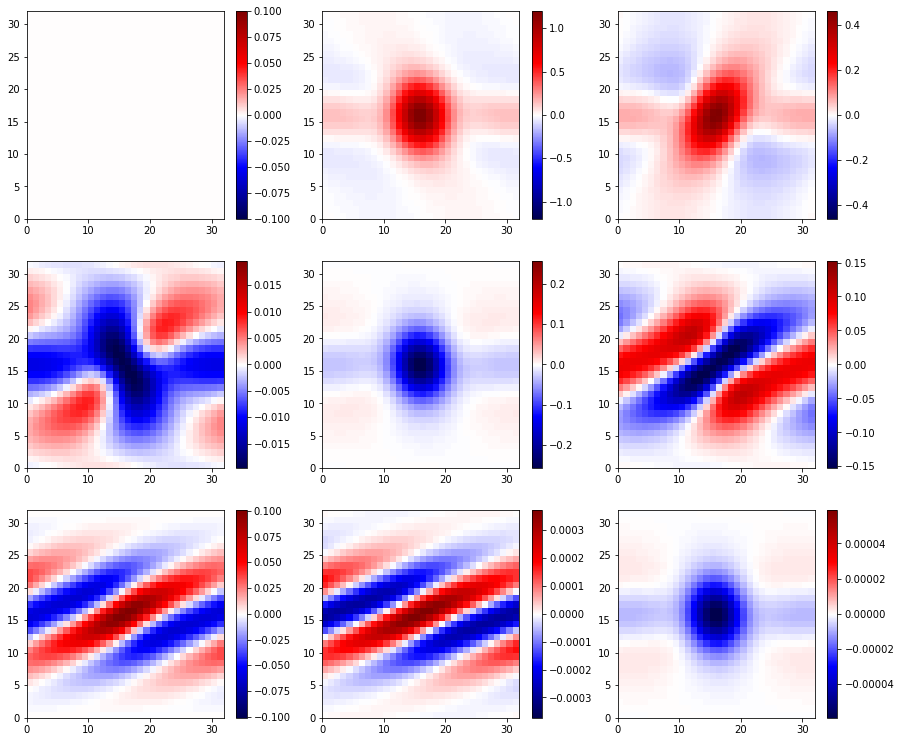

0.0  0.9400735827483364  0.364021219280875  0.016124641335693544  0.2018804555162832  0.10776392057167045  0.06829788106249124  0.00023896972615466497  4.636750989939833e-05  

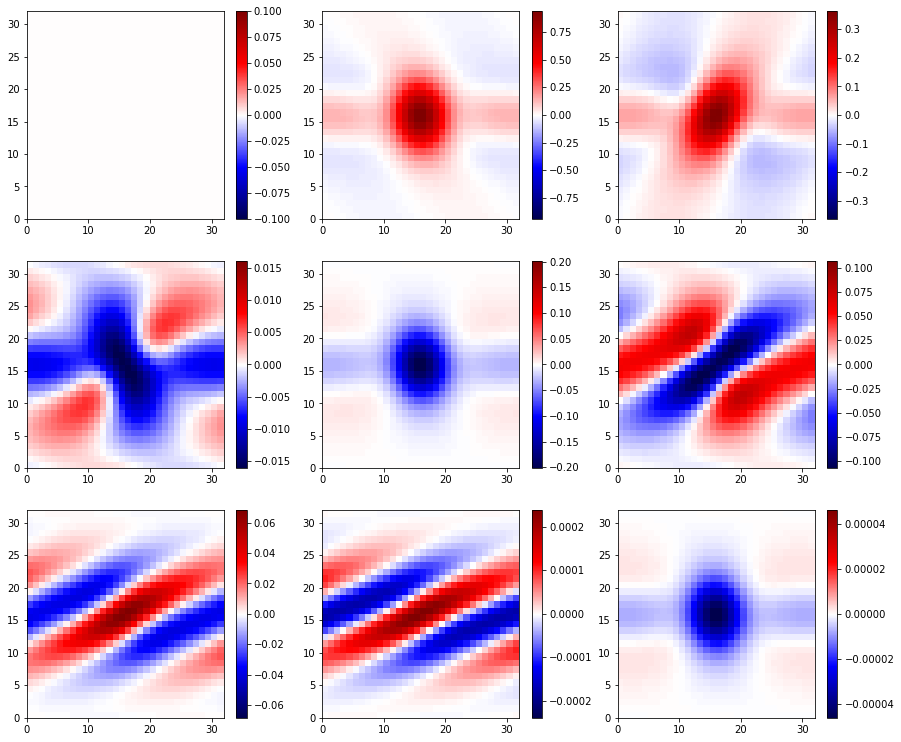

In [22]:
PlotSDfromFT(Sigma_ek)
plt.show()
PlotSDfromFT(Sigma_kpe)
plt.show()

0 0 0.0
0 1 2.7796240700864785
1 0 0.15843321086297288
1 1 0.4070826315574512


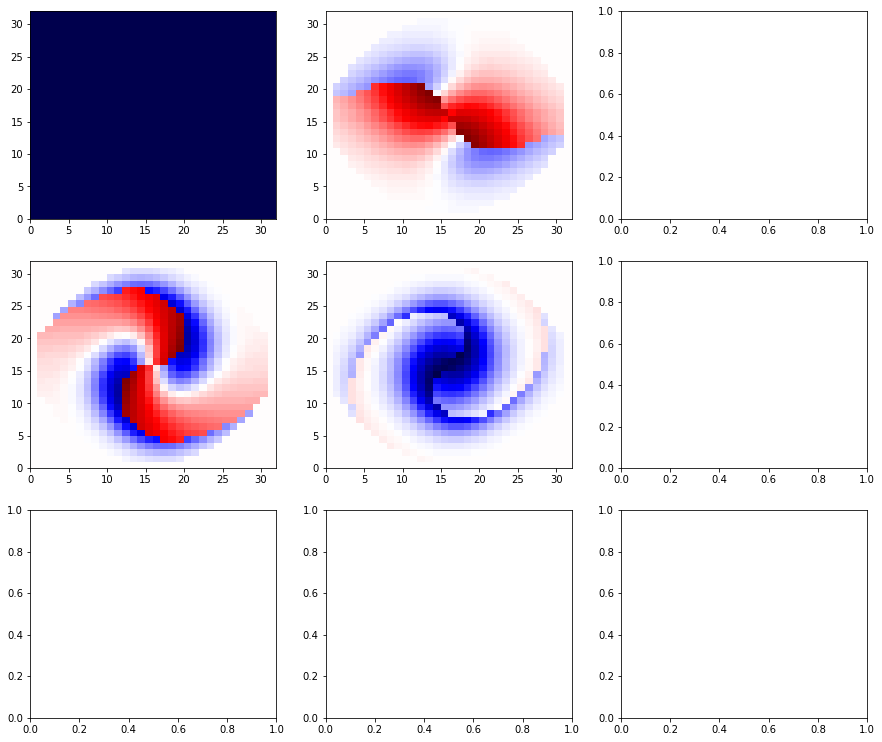

In [74]:
def inverseFT_faster(ftilde):
    nx = ny = 32
    FTarg = 1j*(np.outer(kxmesh,xmesh)+np.outer(kymesh,ymesh)).reshape(nkx,nky,nx,ny)[:,:,:,:,None,None]
    FTint = np.exp(FTarg)*ftilde[:,:,None,None,:,:]
    FTy = np.trapz(FTint,kygrid,axis=1)
    f = np.real(np.trapz(FTy,kxgrid,axis=0)+np.trapz(np.conj(FTy),kxgrid,axis=0))/(2.*np.pi)**2
    return f

def PlotZWfromFT(ftilde):
    ncol = 3
    nrow = 3
    nPSh = int(nPS/2)
    npan = ncol*nrow
    skip = int(ntime/npan)

    fig,ax = plt.subplots(nrow,ncol,figsize=(15,13))
    for i in range(2):
        for j in range(2):
            nt = skip*(i*nrow + j)
            ZW_k = ftilde[nt,]
            ZW_x = inverseFT_faster(ZW_k)
            ZW = ZW_x[nPSh,nPSh]
            vmx = np.abs(ZW).max()
            print (i,j,vmx)
            ax[i,j].pcolormesh(ZW,vmin=-vmx,vmax=vmx,cmap='seismic')
    plt.show()
    return ZW_x
ZW_x = PlotZWfromFT(f_kze+f_kpe)

(32, 32, 32, 32)


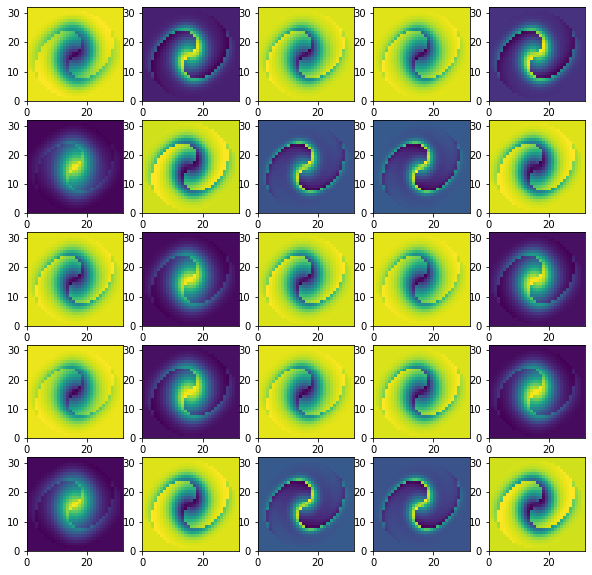

In [81]:
print (ZW_x.shape)

vmax = np.abs(ZW_x).max()
ncol = nrow = 5
fig,ax = plt.subplots(ncol,nrow,figsize=(10,10))
for i in range(ncol):
    for j in range(nrow):
        nx = 1*(i+1)+12
        ny = 1*(j+1)+12
        vmax = np.abs(ZW_x[nx,ny]).max()
        ax[i,j].pcolormesh(ZW_x[nx,ny])#,vmin=-vmax,vmax=vmax,cmap='seismic')
        

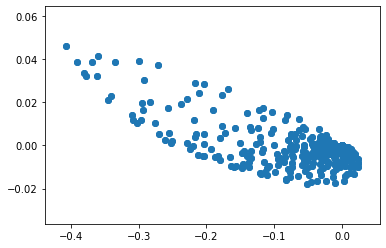

In [79]:
ZWc = ZW_x[16,16]
ZWd = ZW_x[14,16]
ZWcd = ZWc[ZWc!=0]
ZWdd = ZWd[ZWc!=0]
plt.scatter(ZWc,ZWd)